In [1]:
pip install pandas numpy arch scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 8.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import norm
import matplotlib.pyplot as plt

<ipython-input-2-e274ce9ffd18>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv("../Clean Data/IN_Cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1087 non-null   object 
 1   PX_LAST      1087 non-null   float64
 2   PX_VOLUME_x  1087 non-null   int64  
 3   NIFVIX       1087 non-null   float64
 4   IN003M       1087 non-null   float64
 5   PX_BID       1087 non-null   float64
 6   PX_VOLUME_y  1087 non-null   int64  
 7   PX_ASK       1087 non-null   float64
 8   PX_SPREAD    1087 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 72.3+ KB


In [30]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes option price.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return C
def black_scholes_put(S, K, T, r, sigma):
    """
    Calculate Black-Scholes put option price.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    P = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return P

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

df['Log_Returns'] = np.log(df['PX_LAST'] / df['PX_LAST'].shift(1))
df = df.dropna()  # Remove any NaN values resulting from shift operation

model = arch_model(
    df['Log_Returns'],
    vol='Garch',
    p=1,
    q=1,
    dist='normal',
    rescale=False,
    x=df[['PX_VOLUME_x']]
    )
model_fit = model.fit(disp="off")
df['GARCH_Volatility'] = model_fit.conditional_volatility

df['Sigma_Annualized'] = df['GARCH_Volatility'] * np.sqrt(252)
df['Daily_STIR'] = df['IN003M']/252

df['S'] = df['PX_LAST']              # Spot price (index price on that day)
df['K'] = df['PX_LAST']              # Set strike price equal to spot price (ATM option)
df['T'] = 1/252                      # Time to expiry (1 day in years)
df['r'] = df['Daily_STIR']               # Daily short-term interest rate (SOFR3M)
df['Sigma'] = df['GARCH_Volatility'] # Use annualized GARCH volatility as sigma

df['Call_Price'] = df.apply(
    lambda row: black_scholes_call(row['S'], row['K'], row['T'], row['r'], row['Sigma']), axis=1
    )
df['Put_Price'] = df.apply(
    lambda row: black_scholes_put(row['S'], row['K'], row['T'], row['r'], row['Sigma']), axis=1
    )

df['Theoretical_Spread'] = (df['Call_Price'] + df['Put_Price']) / 2

df_Model = (df[['Date', 'PX_LAST', 'GARCH_Volatility', 'Sigma_Annualized', 'NIFVIX', 'IN003M', 'Daily_STIR', 'Theoretical_Spread',]])
df_Model.info()
df_Model.to_csv("../Data Model/IN_Model.csv", index=False)

<ipython-input-30-5a27fd6ac30d>:18: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, 1085 to 0
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1086 non-null   datetime64[ns]
 1   PX_LAST             1086 non-null   float64       
 2   GARCH_Volatility    1086 non-null   float64       
 3   Sigma_Annualized    1086 non-null   float64       
 4   NIFVIX              1086 non-null   float64       
 5   IN003M              1086 non-null   float64       
 6   Daily_STIR          1086 non-null   float64       
 7   Theoretical_Spread  1086 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 76.4 KB


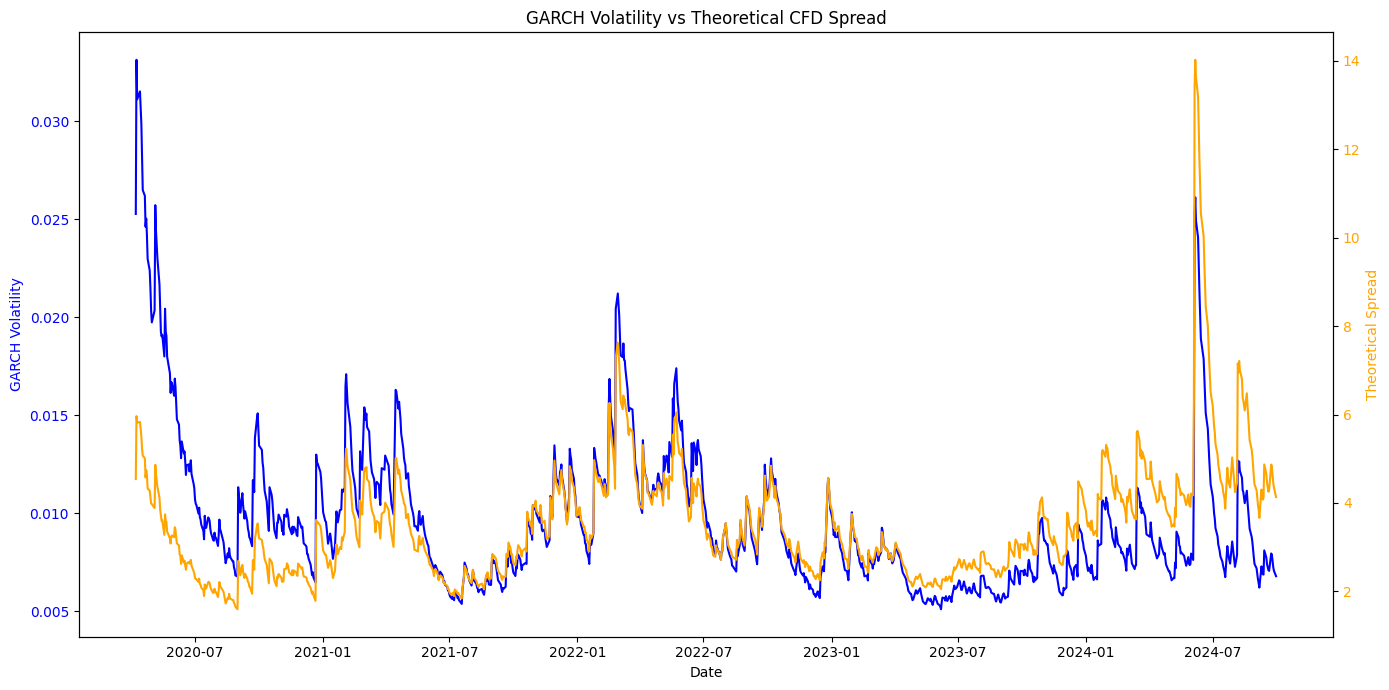

In [31]:
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(df['Date'], df['GARCH_Volatility'], color='b', label='GARCH Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('GARCH Volatility', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Theoretical_Spread'], color='orange', label='Theoretical Spread')
ax2.set_ylabel('Theoretical Spread', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('GARCH Volatility vs Theoretical CFD Spread')
fig.tight_layout()

plt.show()